## Topic Modeling - a technique in NLP that uncovers main ideas or patterns by grouping words that occur frequently together. 

*"It's vital to remember who you really are. It's very important. It isn't a good idea to rely on other people or things to do it for you, you see. They always get it wrong." - Sourcery*

*"I meant," said Ipslore bitterly, "what is there in this world that truly makes living worthwhile?" Death thought about it. CATS, he said eventually. CATS ARE NICE."*

Topics and themes from Discworld typically include religion, heroes, courage, the afterlife, sacrifice, loyalty, politics and so on.. It all sounds a little sombre, but there are also a lot of heartwarming, witty, humourous and lovely moments in there (those are my favourite parts!)

Let's see what Topic Modeling unveils for us. Here we will use LDA, a popular statistical technique that identifies clusters of words that frequently appear together, indicating different themes or topics.

In the next steps, we will conduct text extraction, cleaning, lemmatizing and running the LDA model.

In [1]:
import fitz  # PyMuPDF for extracting text
import faiss  # FAISS-GPU
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import gensim
from gensim import corpora
from gensim.models import LdaModel
import spacy
import pandas as pd
from utils.utils import plot_coherence_values, compute_coherence
import importlib
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser'])

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [3]:
def extract_text_from_pdfs(pdf_directory):
    text = ""
    
    # Loop through all files in the directory
    for filename in os.listdir(pdf_directory):
        if filename.endswith(".pdf"):  # Ensure only PDFs are processed
            pdf_path = os.path.join(pdf_directory, filename)
            print(f"Extracting text from: {filename}")

            with fitz.open(pdf_path) as doc:
                for page in doc:
                    text += page.get_text("text") + "\n"

    return text

In [4]:
%%time
text = extract_text_from_pdfs("./books")

Extracting text from: 09-eric.pdf
Extracting text from: Light Fantastic - PDF Room.pdf
Extracting text from: sourcery.pdf
Extracting text from: The-Colour-of-Magic.pdf
Extracting text from: the_last_hero.pdf
CPU times: total: 1.17 s
Wall time: 1.22 s


In [5]:
print(f'{len(text)} total words extracted')

1628213 total words extracted


#### With a whole bunch of text extracted from 5 books, we only have 1 document. This isn't ideal for LDA modeling as it needs multiple distinct documents to effectively learn topic distributions and capture meaningful patterns. This use case isn't like a study of twitter tweets either, where each tweet can be treated as one document.

So how do we do this? We chunk the text into documents. And how many words is suitable for each document? 

https://www.matthewjockers.net/2013/04/12/secret-recipe-for-topic-modeling-themes/ 

"By chunking each novel into smaller pieces, we allow the model to discover themes that occur only in specific places within novels and not just across entire novels."

500 - 1000 word chunks are said to be good when modeling models, as it typically is the length for a scene to develop and happen.

Here, we use 700 words arbitrarily.

In [6]:
def chunk_text(text, chunk_size):
    words = text.split()
    return [" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

documents = chunk_text(text, 700)  # Each document has 700 words

### But first, ~~coffee~~... clean and process text
To start, we clean and process the texts to remove any potential 'noise' that can result in an inaccurate representation of the word distributions. For example, stop-words such as 'and', 'the', 'is' and so on contain little value for this task and should be removed.

In [7]:
default_stopwords = set(stopwords.words('english'))
custom_stopwords = {'copyright','pratchett', 'terry', 'www', 'com', 'http',
                    'publisher','title', 'ebook', 'ebooks', 'edition', 'personal', 'man', 'wizard', 'rincewind', 'twoflower','nijel',
                    'mobipocket', 'version', 'corporate', 'sold', 'generate', 'usage', 'file', 'purchase', 'thing'}
                    
extended_stopwords = default_stopwords.union(custom_stopwords)
# print(extended_stopwords)

In [8]:
# Function to clean and preprocess each document
def preprocess_document(text):
    """Cleans, tokenizes, removes stopwords"""
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Tokenization
    tokens = word_tokenize(text.lower())  # Convert to lowercase
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in extended_stopwords]
    
    return filtered_tokens  # Returning a list of words

# Preprocess all documents
processed_docs = [preprocess_document(doc) for doc in documents]
# print(f"Processed Documents: {processed_docs[:3]}")  # Check first 3


#### Bigrams and trigams helps the LDA model recognise meaningful multi-word expressions. For example, 'machine learning'. Without bigrams, it would just be understood as 'machine' and 'learning', which negates its true meaning in the corpus.

In [9]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=30)  # Tune threshold
trigram = gensim.models.Phrases(bigram[processed_docs], min_count=5, threshold=30)

# Convert to Phrasers for efficiency
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Apply bigram/trigram transformation
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Apply bigrams & trigrams
bigrams = make_bigrams(processed_docs)
trigrams = make_trigrams(bigrams)
# print(f"trigrams Example: {trigrams[:3]}")


### Lemmatization is a powerful technique to reduce noise and enhances coherence in the text.

For example, 'running', 'run', 'ran' would be interpreted by LDA to be all different words (hence noise), though they mean the same. By reducing them to their lemmas, then we would have improved coherence in the inputs for the model.

POS tags also enhances the meaning of words - it distinguishes words that spell the same but mean different things. If a word 'fly' is tagged a noun, then obviously it would be a different word from 'fly' that is tagged a verb. 

Here the lemmatized texts that are allowed are those tagged as nouns or adjectives.

In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Lemmatizes a list of tokenized documents."""
    texts_out = []
    for doc in texts:
        doc_nlp = nlp(" ".join(doc))  # Process full text
        texts_out.append([token.lemma_ for token in doc_nlp if token.pos_ in allowed_postags])
    return texts_out

# Apply Lemmatization
lemmatized_texts = lemmatization(trigrams, allowed_postags=['NOUN', 'ADJ'])
# print(f"Lemmatized Example: {lemmatized_texts[:3]}")


In [25]:
# Step 1: Create a Dictionary
id2word = corpora.Dictionary(lemmatized_texts)
print('Total Vocabulary Size:', len(id2word))

# # Step 2: Filter extreme words (too rare or too common)
# id2word.filter_extremes(no_below=5, no_above=0.8)

# Step 3: Convert each document into a Bag-of-Words (BoW) representation
corpus = [id2word.doc2bow(text) for text in lemmatized_texts]

# Check BoW representation
# print(f"BoW Example: {corpus[:3]}")
print(f'{len(id2word)} unique tokens after filtering')
print(f"Total documents: {len(corpus)}")

Total Vocabulary Size: 9085
9085 unique tokens after filtering
Total documents: 407


#### For the sake of checking that there are not too many common words, we check the top 10 high frequency words.

The top 10 words originally are shown below. As we can see, there is not much value in having Rincewind's name repeated >2000 times, nor knowing that the word 'say' was repeated more than 4000 times in the text. It does give some information about Terry Pratchett's writing style (lots of action and talking!), but we still don't know the themes of the books.


<img src="images/original_top_10.png" width="100" height="225" style="float:left; margin-right:10px;" />


So let's see how the corpus has changed after the cleaning and lemmatization.

In [12]:
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
            if id2word[idx] in dict_corpus:
                dict_corpus[id2word[idx]] += freq
            else:
                dict_corpus[id2word[idx]] = freq
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

# top 10 high-frequency words in descending order.
dict_df.sort_values('freq', ascending=False).head(10)

,freq
time,543
good,398
little,371
people,371
way,369
hand,365
wizard,347
thing,340
eye,335
magic,329


Now, these words give a good hint of the main elements in Discworld. The concept of time and eternity, good things, little people (likely dwarfs), wizards, and magic. 'Way' and'hand' suggests action and wayfinding, or heroes (rincewind) finding their way out of trouble, and 'eye' indicating lots of visual. 

This, however isn't enough to shed light on the main topics, and therefore we have our next steps for topic modeling!


### LDA Model with BOW

Note that with a Bag-of-Words (BoW) representation, it simply takes into account the frequency of the words. We should compare BOW with TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF downweights common words and upweights rare but important words, and that could help with the modeling outcome.

Let's try with BOW method first, with an arbitrary num_topics = 3 for a start.

In [13]:
# Train LDA Model
lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word, 
    num_topics=3,  # arbitrary, we should tune this
    passes=10, 
    alpha='auto'
)

for topic_id, words in lda_model.show_topics(formatted=False):
    print(f"Topic {topic_id}: {[word[0] for word in words]}")


Topic 0: ['time', 'wizard', 'magic', 'hand', 'voice', 'eye', 'way', 'good', 'foot', 'head']
Topic 1: ['good', 'people', 'time', 'god', 'big', 'little', 'thing', 'head', 'old', 'eye']
Topic 2: ['time', 'people', 'little', 'way', 'good', 'small', 'thing', 'hand', 'luggage', 'world']


In [14]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_score}')


Coherence Score: 0.25627944001400593


### LDA Model with TF-IDF

In [15]:
#create TFIDF corpus
from gensim import models
model_tfidf = models.TfidfModel(corpus)
corpus_tfidf = model_tfidf[corpus]

In [16]:

lda_model_tfidf = gensim.models.ldamodel.LdaModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    alpha='auto',
    num_topics=3,  # arbitrary, we should tune this
    passes=10)

# Print topics
for topic_id, words in lda_model_tfidf.show_topics(formatted=False):
    print(f"Topic {topic_id}: {[word[0] for word in words]}")

Topic 0: ['dragon', 'luggage', 'wizard', 'spelter', 'god', 'death', 'coin', 'voice', 'demon', 'magic']
Topic 1: ['dragon', 'trymon', 'galder', 'smut', 'tree', 'sword', 'tezuman', 'branch', 'kingdom', 'death']
Topic 2: ['rjinswand', 'coin', 'prisoner', 'magic', 'tezuman', 'hat', 'tower', 'matter', 'lamp', 'king']


In [17]:
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=lemmatized_texts, dictionary=id2word, coherence='c_v')
coherence_score_tfidf = coherence_model_lda_tfidf.get_coherence()
print(f'Coherence Score: {coherence_score_tfidf}')

Coherence Score: 0.3275622253557577


With this coherence score <0.5 for both BOW and TF-IDF, we have to improve model performance.

We can do this by testing out a range of num_topics that can give us the highest evaluation. 

We start with TF-IDF first, since it has a slightly higher coherence value than the BOW corpus.

In [18]:
# coherence values for tfidf corpus across the range of num_topics
coherence_val_tfidf = compute_coherence(dictionary=id2word,corpus=corpus_tfidf, texts=lemmatized_texts, start=2, limit=100, step=5)

Highest coherence score: 0.6335 at 12 topics


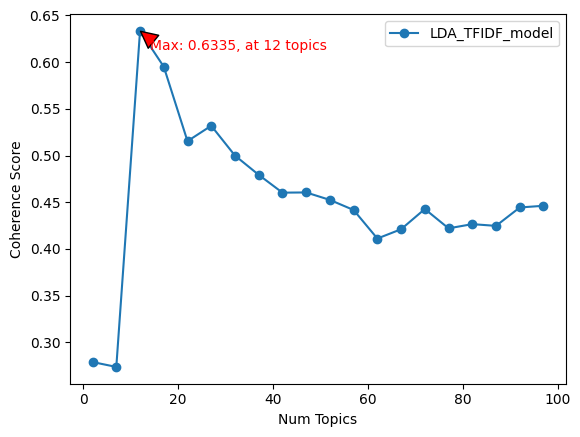

In [19]:
plot_coherence_values(coherence_val_tfidf, start=2, limit=100, step=5, plot_title='LDA_TFIDF_model')

#### A coherence score of 0.57 is acceptable, but not amazing. Let's see if we can visualise the topics to improve the modeling a little better.

In [20]:

lda_model_tfidf = gensim.models.ldamodel.LdaModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    alpha='auto',
    num_topics=12,
    passes=10)

for topic_id in range(12):
    words = lda_model_tfidf.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id}: {[word[0] for word in words]}")

Topic 0: ['broadman', 'demon', 'sire', 'spelter', 'scrofula', 'ipslore', 'wilderness', 'volunteer', 'gook', 'parchment']
Topic 1: ['coin', 'tree', 'liarte', 'glacier', 'cap', 'spelter', 'kring', 'rope', 'fern', 'gertrude']
Topic 2: ['suit', 'ferryman', 'monster', 'galder', 'lad', 'ruby', 'master_launchcontroller', 'sacrifice', 'pie', 'craft']
Topic 3: ['coin', 'wine', 'creosote', 'sourcerer', 'seriph', 'spelter', 'color', 'passage', 'wall', 'building']
Topic 4: ['galder', 'decision', 'apocralypse', 'taper', 'hat', 'valve', 'slaver', 'canoe', 'mankind', 'aeon']
Topic 5: ['ipslore', 'wand', 'sconner', 'key', 'match', 'test', 'genius', 'tentacle', 'pit', 'tezuman']
Topic 6: ['shopkeeper', 'sergeant', 'coin', 'shop', 'astrologer', 'war', 'abrim', 'soldier', 'sir', 'ape']
Topic 7: ['lackjaw', 'prisoner', 'dwarf', 'pit', 'enemy', 'vassenego', 'chair', 'lock', 'wash', 'commander']
Topic 8: ['abrim', 'vizier', 'broomstick', 'guard', 'seriph', 'hat', 'zlorf', 'swire', 'brief', 'bottle']
Topic 9

#### Just by eyeballing these topics, we can already determine that the topics of gods, evil, death, magic, wizards, religion. Now let's visual them with a handy tool pyLDAvis that breaks down the topics further into their elements.

In [21]:
pyLDAvis.enable_notebook()
visualise_topics = gensimvis.prepare(lda_model_tfidf, corpus, dictionary=id2word, mds='mmds')
pyLDAvis.display(visualise_topics)

#### Interpretation and fine-tuning

Topic 10, labled as "1" is the largest and the furthest away from the other topics, which are closer together and more evenly sized. That topic 10 is the largest, it indicates that the elements that make up the topic are dominant across the documents, but could not be categorized into the other topics. 

When we hover over "1", we see dragon, death, god, magic.. which are typical themes of fantasy and mythology. However, we also see 'tree', 'world', 'book', 'door', 'thing' - terms that are not really high value for topics.

In that case, we can try removing these general words, and hopefully we should see a better coherence score. 

After re-running the lda model again with the newly tuned corpus, we see a drop in the coherence score from 0.5701 to 0.5307. There is some improvement in the distribution of the circles when visualising, but it seems difficult to remove the recurring elements. We should note that since we are reviewing the topics of one author, with consistent themes across his books, circle "1" is likely to stay. 

<img src="images/coherence_finetuning.png" width="400" height="300" style="float:left; margin-right:10px;" />

<img src="images/new_breakdown.png" width="400" height="300" style="float:left; margin-right:10px;" />



#### Just for confirmation (and no surprises!), let's run the LDA again for the BOW corpus across the range of num_topics.

In [22]:
coherence_val_bow = compute_coherence(dictionary=id2word,corpus=corpus, texts=lemmatized_texts, start=2, limit=100, step=5)

Highest coherence score: 0.2853 at 92 topics


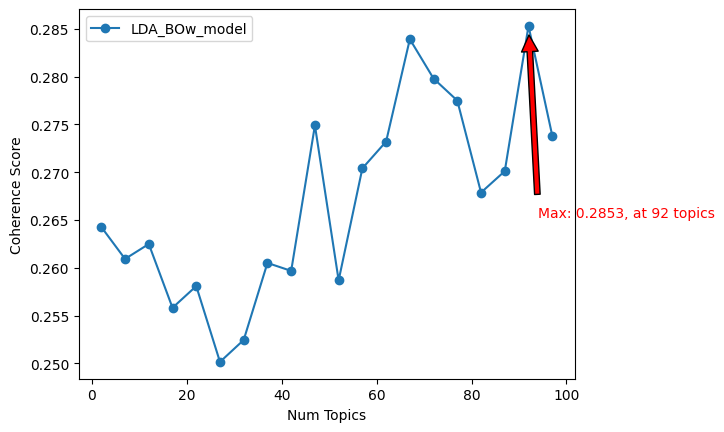

In [23]:
plot_coherence_values(coherence_val_bow, start=2, limit=100, step=5, plot_title='LDA_BOw_model')

This confirms that using the TF-IDF method works for this corpus, where reducing the common words and increasing the importance of rare words are more effective in modeling the topics of Terry's works.

If we were to try fine-tuning the model again, perhaps we could increase the size of the corpus, and include Terry's works from outside of the Discworld series. 
